![walnut-gulch](./img/WG-nologo.png)

Walnut Gulch Experimental Watershed in southeastern Arizona by Sentinel-2. Credits: Sentinel-hub (https://www.sentinel-hub.com/)

# Implementation of Optical Trapezoid Model (OPTRAM) with Sentinel 2 

Author : Jose Vicente Yago Martinez - jvyagomartinez@gmail.com

The Optical Trapezoid Model (OPTRAM) was developed to overcome the limitations of the Thermal-Optical Trapezoid Model (TOTRAM), i.e., non aplicability to satellites that do not provide thermal data, and the requirement of parametrization for each individual date. Based on Short Wave Infrared Reflectance (SWIR), Normalized Difference Vegetation Index (NDVI) and in situ measurements at surface level, the OPTRAM has demostrated to be a significant advance for remote sensing of soil moisture with great importance to undestand seasonal dynamics, water resource planning and agricultural production.

The present work its a implementation of the OPTRAM based on the paper [sadegui et al 2017](https://www.sciencedirect.com/science/article/abs/pii/S0034425717302493), however some differences are worth mentioning: 

- Only the Galnut Gulch Watershed area has been modelized, leaving aside Little Washita.
- 71 Sentinel2 BOA (Level 2A) images corresponding to 2019 TOA (Level 1C) have been used, in contrast to the 17 images corresponding to the year 2015 used in the article. Because of BOA level, radiometric, atmospheric and geometric corrections were not needed.

- The Sentinel2 [SCL](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) band was used as a single mask to filter water bodies, clouds, saturated pixels, etc, as a consequence, the clustering and water body classification models of the original article were not necessary.

- Both methods for the estimation of the $\theta_d$, $\theta_w$ coefficients, corresponding to the two scenarios presented in the original article have been implemented, although only the first scenario is fully developed.


Adittionaly in some parts, the implementation makes advantage of parallel computations to process the tens of millions of data to be computed in a single computer.

This notebook is divided in the following sections: 


1. [Python packages](#section_1)
2. [Functions](#section_2)
3. [Region of study](#section_3)
4. [Data](#section_4)
 - [4.1 Sensor](#section_4_1)
 - [4.2 Satellite](#section_4_1)
5. [Data fusion](#section_5)
6. [Model parametrization](#section_6)
7. [W maps](#section_7)

To a fully understand of this work the reader should first become familiar with the original paper since the theoretical background is not discussed here.

<a id='section_1'></a>
## 1 - Python packages

In [40]:
# MODULE                                             # DESCRIPTION
import numpy as np                                   # scientific computing
import numpy.ma as ma                                # numpy masked arrays
import pandas as pd                                  # data analysis and manipulation
import geopandas as gpd                              # geospatial data analysis
import utm                                           # bidirectional UTM-WGS84 converter
import folium                                        # interactive data visualization
import re                                            # regular expressions
from osgeo import gdal, gdalconst                    # raster and geospatial data proc.
import rasterio as rs                                # raster and geospatial data proc.
import matplotlib.pyplot as plt                      # create visualizations
import seaborn as sns                                # create visualizations
import datetime                                      # datetime manipulation
import glob                                          # unix pathname expansion
import haversine as hs                               # distances between points
import dask                                          # parallel computing
from dask.distributed import Client                  # set custom parameters in cluster
import dask.dataframe as dd                          # manipulation of lazy dask dfs
import datashader as ds                              # visualization for big data
import colorcet as cc                                # colormaps for datashader 
from sklearn import linear_model                     # regression 
from sklearn.metrics import mean_absolute_error      # to compute MAE
from sklearn.metrics import mean_squared_error       # to compute RMSE
from sklearn.metrics import r2_score                 # to compute R^2
import xarray as xr                                  # efficent ND arrays manipulation
import rioxarray                                     # rasterio xarray extension
from matplotlib.colors import LinearSegmentedColormap# create custom color maps
from shapely import geometry                         # manipulate planar features
from shapely.geometry import Point                   # manipulate planar features
import pickle                                        # load/save pickle datasets
import os                                            # miscellaneous OS interfaces
from pathlib import Path                             # 
import math                                          #
import random                                        #  
import sys

In [41]:
currentdir = os.path.dirname(os.path.realpath('../optram.py'))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)
from OPTRAM import optram

<a id='section_3'></a>
## 3 -  Region of study

The South Watershed Reseach Center (SWRC) operates the Walnut Gulch (WG) Experimental Watershed in southeastern Arizona as an outdoor laboratory for studying semiarid rangeland hydrologic, ecosystem, climate, and erosion processes.

The SWRC hidrology network is densely instrumented with sensors associated with weather stations, soil profile trenches and 52 near-surface soil hydrology sensors co-located with rain gauges.

The WG wathersed is part of the San Pedro river basein and extends over an area of 148Km² covered with shrubs (two thirds) adnd grassland (one third). 
The climate is semiarid with an average annual temperature of 17.7 ºC and average annual precipitation of 350 mm, commonly falling between April and September. 
Soils are classified as gravely and sandly loams with a high percentage of rock and gravel close to the soil surface. - Sadegui et al 2017

For more information about the area, check this links: 

- https://www.tucson.ars.ag.gov/dap/
- https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html

For the year 2019, 19 sensors with 5 cm Volumetric Water Content (%) are available. The process of the sensor data retrieving is detailed in this issue:
- https://github.com/VicenteYago/OPTRAM/issues/6

In [42]:
swrc_wg = gpd.read_file('./WG-boundary/boundary/boundary.shp')

Plotting with Folium requires lat, long data, so we have to convert from UTM

In [43]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc_wg.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc_wg.geometry[0].exterior.coords.xy[1])) : 
    points.append(optram.utm_to_latlon(coords = [x[i], y[i]],
                                zone_number = utm_N,
                                zone_letter = utm_Z))
 

points_rev = [(y,x) for x,y in points]
swrc_wg['geometry'] = geometry.Polygon(points_rev)

Also we want to plot the locations of ground probes: 

In [44]:
# https://www.tucson.ars.ag.gov/dap/dap_docs/soil.html


sensor_coords_utm = {'rg13vt19'  : [586110, 3510185],
                     'rg14vt19'  : [585442, 3507187],
                     #'rg18vt19'  : [586710, 3508098],
                     'rg20vt19'  : [587480, 3504939],
                     'rg28vt19'  : [590624, 3509990],
                     'rg34vt19'  : [590946, 3507458],
                     'rg37vt19'  : [593303, 3506068],
                     'rg40vt19'  : [593360, 3510286],
                     'rg46vt19'  : [595289, 3508655],
                     'rg57vt19'  : [596089, 3510781],
                     'rg69vt19'  : [603916, 3515463],
                     'rg70vt19'  : [604288, 3514207],
                     'rg76vt19'  : [582624, 3509679],
                     'rg82vt19'  : [600154, 3511680],
                     'rg83vt19'  : [589679, 3512426],
                     'rg89vt19'  : [596308, 3513931],
                     'rg92vt19'  : [581888, 3511774],
                     'rg100vt19' : [593266, 3504720]
}

sensors_coords = {s_key : optram.utm_to_latlon(s_utm, utm_N, utm_Z) 
                  for s_key, s_utm in sensor_coords_utm.items()}

m = folium.Map(location = [31.713068,  -110.025442],
               zoom_start = 11,
               tiles = "CartoDB positron")

for _, r in swrc_wg.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
    
for sensor_key, sensor_coords in sensors_coords.items():
    
    folium.Marker(sensor_coords, popup=sensor_key).add_to(m)
    m.add_child(folium.ClickForMarker(popup="Waypoint"))

m

The soils sites are evenly distruted along the WG extension

 Shapefile to geojson conversion, the .geojson its needed to download the Sentinel 2 images.

In [45]:
swrc_wg.to_crs(epsg=4326)
swrc_wg.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

/home/vyago/miniconda3/envs/optram/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


<a id='section_4'></a>

## 4 - DATA

The OPTRAM models needs intensive data from surface soil moisture sensors and satellite images. In the following subsections both sources will be detailed. This graphs summarizes the process of data processing: 

<img src="./img/scheme_full.png" alt="Drawing" style="width: 300px;"/>

- **1-3** : Sensor processing, the filtering of incomplete sensors will be performed here.
- **4-8** : Very complex but made easy by [sen2r](http://sen2r.ranghetti.info/index.html) library in R, rasterio and gdal in python.
- **9**   : This data fusion is key to obtain a full implementation of the OPTRAM model. The sensor readings of each station are matched with the nearest pixels of each image at the acqusition time, allowing for volumetric content water (%) predictions once the model is validated. Aditionally a big speed up is achieved using the parallel library [Dask](https://dask.org/). 
- **10**  : The Scheme Classification Layer ([SCL](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm)) already computed by Copernicus is used to mask the defective pixels, i.e., clouds, snow, shadows, etc.
- **11**  : Finally, with the filtered data and inSitu fusion observations the OPTRAM can be fitted.

<a id='section_4_1'></a>
### 4.1  Sensor 

The OPTRAM model is intended for near surface soil water content estimation, so the SM5 (5 cm depth) its the only level we parse. The following document presents a comprehensive description of the data retrieved from the sensors: 
- https://www.tucson.ars.ag.gov/metDAP/MetandSoil_ColumnHeaders.pdf

In [46]:
 %%time

sensor_path = "./sensor_data"
sensors_df = {}
    
if False: 
    # TODO : check existence of sensor_path folder
    names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
    url_base = 'https://www.tucson.ars.ag.gov/metDAP/'
    for sensor_key,_ in list(sensors_coords.items()) :
        print("Processing sensor %s" % sensor_key)
        try: 
            if 'rg' in sensor_key :

                sensors_df[sensor_key] = pd.read_csv(url_base + 'RaingageSiteData/' + sensor_key +'.out',
                                                     sep='\,', 
                                                     names = names,
                                                     engine='python')
            else :
                sensors_df[sensor_key] = pd.read_csv(url_base + 'SoilProfileSiteData/' + sensor_key +'.out',
                                                     sep='\s+', 
                                                     names = names,
                                                     engine='python')


            sensors_df[sensor_key]['datetime'] = (pd.to_datetime(sensors_df[sensor_key]['year'] * 1000 + sensors_df[sensor_key]['day'], format='%Y%j') 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["hr"], unit="h") 
                                                  +
                                                  pd.to_timedelta(sensors_df[sensor_key]["mn"], unit="min"))

            sensors_df[sensor_key].set_index('datetime', inplace=True)
            sensors_df[sensor_key].replace(6999, None, inplace=True) 
            sensors_df[sensor_key].to_parquet(os.path.join(sensor_path, sensor_key+".parquet"), engine="fastparquet")

            #print(sensors_df[sensor_key].index)


        except Exception as e :
            print("An error occurred while reading data for sensor %s " % sensor_key)
            print("Original message: %s " % e)
            sensors_df.pop(sensor_key, None)
            sensors_coords.pop(sensor_key, None)


CPU times: user 274 µs, sys: 0 ns, total: 274 µs
Wall time: 278 µs


Both rg82 & rg83 need custom processing because the datetimes are formatted in a different way, but in this occasion I am going to excluded it.

In [47]:
sensors_coords.pop('rg82vt19',None)
sensors_coords.pop('rg83vt19',None)

(31.743779393724022, -110.05321008063255)

In [48]:
%%time
for sensor_parquet in os.listdir(sensor_path): 
    sensors_df[os.path.splitext(sensor_parquet)[0]] = pd.read_parquet(os.path.join(sensor_path, sensor_parquet), engine="fastparquet")

CPU times: user 55.1 ms, sys: 4.13 ms, total: 59.2 ms
Wall time: 57.8 ms


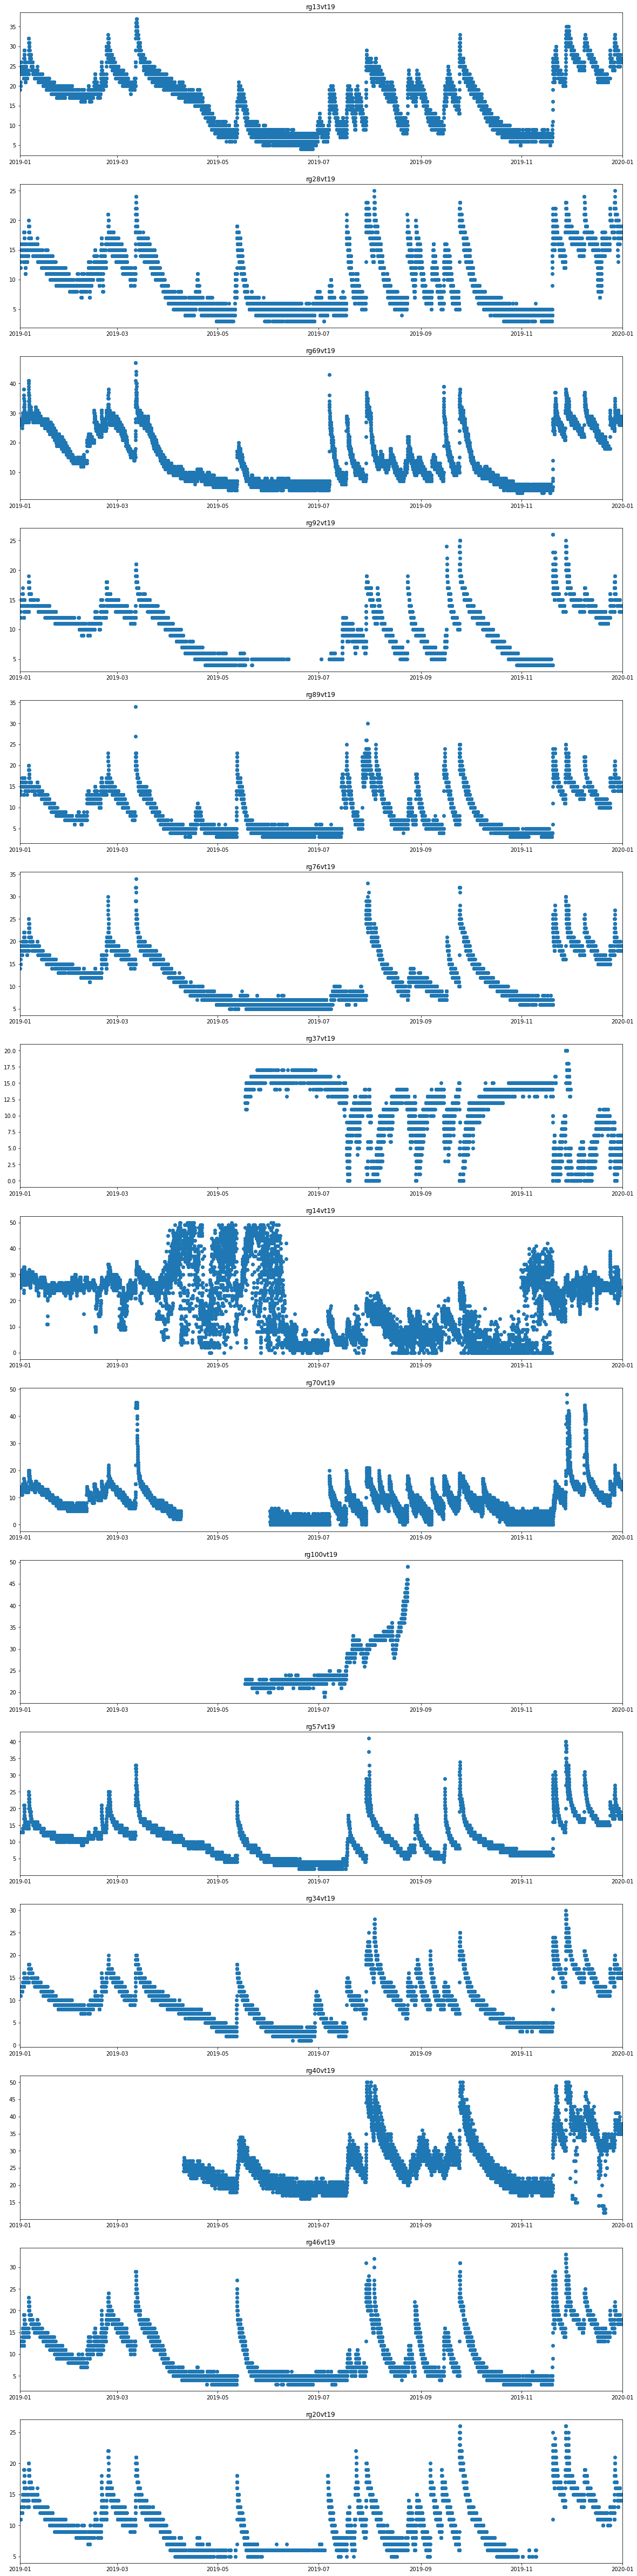

In [49]:
col_nums = 1  
row_nums = math.ceil(len(sensors_df.items()) / col_nums)
plt.figure(figsize=(20, 35))
for i, (k, df) in enumerate(sensors_df.items(), 1):
    df = sensors_df[k]
    plt.subplot(row_nums, col_nums, i)
    plt.scatter(x = df.index, y= df.loc[:,'SM5'])
    plt.title(k)
    plt.xlim([datetime.date(2019, 1, 1), datetime.date(2020, 1, 1)])
plt.subplots_adjust(left=None, bottom=None, right=None, top=2 , wspace=None, hspace=None)

We can see some sensors have wide ranges of lost observations: 
- **rg37vt19**
- **rg100vt19**
- **rg40vt19**

These lost observartions are a serious problem since the OPTRAM needs the max and min values of each series to obtain a meaningful overall fit. Thus we proceed to remove the faulty sensors: 

In [50]:
bad_sensors = ['rg37vt19', 'rg100vt19', 'rg40vt19']

for k in bad_sensors : 
    sensors_coords.pop(k, None)
    sensors_df.pop(k, None)

In [51]:
print(len(sensors_coords.keys()))
print(len(sensors_df.keys()))

print(sensors_coords.keys())
print(sensors_df.keys())

12
12
dict_keys(['rg13vt19', 'rg14vt19', 'rg20vt19', 'rg28vt19', 'rg34vt19', 'rg46vt19', 'rg57vt19', 'rg69vt19', 'rg70vt19', 'rg76vt19', 'rg89vt19', 'rg92vt19'])
dict_keys(['rg13vt19', 'rg28vt19', 'rg69vt19', 'rg92vt19', 'rg89vt19', 'rg76vt19', 'rg14vt19', 'rg70vt19', 'rg57vt19', 'rg34vt19', 'rg46vt19', 'rg20vt19'])


<a id='section_4_2'></a>
### 4.2 - Satellite

The sattelity imagery has been downloaded with the library [sen2r](http://sen2r.ranghetti.info/index.html). This library is very useful to not only download seamlessly but for processing and computation of a varios range of products such as NDVI, here is a list of the tasks performed by the library: 

- Query S2 images in a date range [2019-01-01 to 2020-01-01]
- Download the SAFE products (BOA reflectance) from [gcloud](https://luigi.ranghetti.info/post/safe-gcloud/) and scihub.
- Download SCL band
- Warp tiles to WG shape
- Resample SWIR band from 20mts to 10mts/px to match the R and NIR bands
- Compute NDVI

The library runs in R, so the code its scripted in the file `./sen2r/s2.R`. The outputs are stored in a set of folders specified in the config file : 

In [52]:
! cat ./sen2r/inputs-config_scihub.json | head -n 20

cat: ./sen2r/inputs-config_scihub.json: No such file or directory


Once the images are procesed, the files are located in the following dirs:

In [53]:
BASE_DIR = './'
BASE_DIR_BOA = os.path.join(BASE_DIR, 'sen2r/out/BOA2/')
BASE_DIR_SCL = os.path.join(BASE_DIR, 'sen2r/out/SCL/')
BASE_DIR_NDVI = os.path.join(BASE_DIR, 'sen2r/indices/NDVI/')

In [54]:
BASE_DIR_SAT_IMG_DF = os.path.join(BASE_DIR, 'sat_img_df/')
boa_files = [f for f in os.listdir(BASE_DIR_BOA,) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

UTM coordinates of each pixel will be needed in order to find the nearest pixel to the weather stations, so instead of calculate it in each iteration of the following loop, they are pre-computed taking advantage of the fact that all images have the exact same dimensions.

In [55]:
# -----PRECALCULATED for speedup
# TODO: Parellization will be great, but its not worth bc it will be computed one time 
# and them the result will be loaded for further runnings.
if False :
    print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    boa_dummy  = rs.open(BASE_DIR_BOA + boa_files[0])
    utm_x, utm_y =  get_px_coords_from_raster(boa_dummy,
                                              band = 3, # /10 m/px band
                                              no_data = boa_dummy.nodata)
    print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))

A dataframe representation of each image is built, computing NDVI, STR and SCL resampled values as columns 

$$NDVI = \frac{R_{NIR} - R_{RED}}{R_{NIR} + R_{RED}}$$
$$STR = \frac{(1-R_{SWIR})^2}{2 \cdot R_{SWIR}}$$

In [56]:
if False : 
    
    Path(BASE_DIR_SAT_IMG_DF).mkdir(parents=True, exist_ok=True)
    for idx,file in enumerate(boa_files) : 
        try : 
            now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
            print('[%s] : processing file (%s/%s) %s... \n' % (now, idx, len(boa_files), file))

            boa_fp = BASE_DIR_BOA + file
            raster_date = S2_getDate(boa_fp)
            scl_fp = S2_getIndex(BASE_DIR_SCL, raster_date)
            ndvi_fp = S2_getIndex(BASE_DIR_NDVI, raster_date)

            boa  = rs.open(boa_fp)
            ndvi  = rs.open(ndvi_fp)

            swir = boa.read(11, masked = True)
            ndvi = ndvi.read(1)
            ndvi = np.ndarray.flatten(ndvi)
            ndvi = np.delete(ndvi, ndvi == -9999.0)
            #SWIR2 band 12 http://sen2r.ranghetti.info/articles/outstructure.html
            swir = swir / 10000 
            STR  = ((1-swir)**2)/(2*swir)
            STR  = np.ndarray.flatten(STR)
            STR  = np.delete(STR, STR.mask)
            
            data = {
                'datetime' : S2_get_sensing_dt(boa_fp),
                'ndvi' : ndvi,
                'str'  : STR,
                'utm_x' : utm_x, 
                'utm_y' : utm_y,
                'fpath' : boa_fp
            }
            
            local_df = pd.DataFrame(data)
            local_df.astype({
                'datetime' : 'datetime64[ns]',
                'ndvi' : 'float', 
                'utm_x' : 'float', 
                'utm_y' : 'float',
                'fpath' : 'str'
            })
            local_df = add_scl_col(scl_fp = scl_fp,
                                   ndvi_fp = ndvi_fp,
                                   local_df = local_df,
                                   date = raster_date)            
            local_df.to_parquet(os.path.join(BASE_DIR_SAT_IMG_DF,
                                             datetime.datetime.strftime(raster_date, "%Y-%m-%d")+".parquet"),
                                engine="fastparquet")
                
            #print(local_df)
            
        except Exception as e : 
            print("An error occurred while processing data for file %s " % file)
            print("Original message: %s " % e)

Here is a look at the data of an example image: 

In [57]:
df = pd.read_parquet(os.path.join(BASE_DIR_SAT_IMG_DF, os.listdir(BASE_DIR_SAT_IMG_DF)[0]))
df.head()

datetime      ndvi       str     utm_x      utm_y  \
index                                                                
0     2019-05-10 17:59:19  0.134433  1.709346  605485.0  3515705.0   
1     2019-05-10 17:59:19  0.125568  1.709346  605495.0  3515705.0   
2     2019-05-10 17:59:19  0.127645  1.725245  605505.0  3515705.0   
3     2019-05-10 17:59:19  0.125044  1.725245  605515.0  3515705.0   
4     2019-05-10 17:59:19  0.126282  1.711981  605525.0  3515705.0   

                                                   fpath  scl_value  
index                                                                
0      ./sen2r/out/BOA2/S2B2A_20190510_041_Walnut-Gul...        NaN  
1      ./sen2r/out/BOA2/S2B2A_20190510_041_Walnut-Gul...        NaN  
2      ./sen2r/out/BOA2/S2B2A_20190510_041_Walnut-Gul...        NaN  
3      ./sen2r/out/BOA2/S2B2A_20190510_041_Walnut-Gul...        NaN  
4      ./sen2r/out/BOA2/S2B2A_20190510_041_Walnut-Gul...        NaN

Quick remarks: 
- The `datetime` is the sensing datetime of the image, retrieved with a `sen2r` script.
- Why are `NaN` values in the`scl` column?
  - In sort, its due to a left join, affecting only at some  pixels in the image margins. See this [issue](https://github.com/VicenteYago/OPTRAM/issues/4 ) for more info.

It can be check that `NaN` SCL values are a small fraction of the total

In [58]:
np.unique(df['scl_value'], return_counts = True)

(array([ 7.,  8.,  9., 10., 11., nan]),
 array([     12,  269793, 1102039,  103692,     191,    1823]))

<a id='section_5'></a>
## 5 - Data fusion

To match the satellite values with the sensor readings, first the closest pixel to each station needs to be find.

The following code precalculates the distance (haversine) to the >1M points of the satellite image to each of the sensing stations (~13). The precalculation is done with a dummy image (first boa file) because all the ~74 images have the same dimensions and georeference.

In [59]:
if False:
    print('[%s] : ------- PRECOMPUTING  -------\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    haversine_dists = get_distances_pxs_to_sensor(boa_dummy = boa_dummy,
                                                  sensors_coords = sensors_coords,
                                                  utm_x = utm_x,
                                                  utm_y = utm_y)
    print('[%s] : ----- PRECOMPUTING DONE -----\n' % (datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")))
    with open('./haversine_dists.pkl', 'wb') as f:
        pickle.dump(haversine_dists, f)
        
with open('./haversine_dists.pkl', 'rb') as f:
    haversine_dists = pickle.load(f) #TODO: Will be great to save as parquet.

From here to the end we will use **Dask** to speedup the computations unlocking the parallelism at hardware level, to learn more about it : 

- https://dask.org/
- https://docs.dask.org/en/latest/dataframe.html


First of all the client need to be set, I have followed the recommendations :
[_You want the number of processes times the number of threads to equal the number of cores._](https://stackoverflow.com/questions/51099685/best-practices-in-setting-number-of-dask-workers)  

In [60]:
# Ryzen 5 2600: 6 cores 12 threads, 16 GB RAM
# Workaround to achieve scheduler similar to processes=False
client = Client(memory_limit='16GB', # keep to 12
                processes = True,
                n_workers = 1,
                threads_per_worker = 12)
client

/home/vyago/miniconda3/envs/optram/lib/python3.8/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36013 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44871' processes=1 threads=12, memory=14.90 GiB>

Loading lazily all the dataframes : 

In [61]:
ddf = dd.read_parquet(BASE_DIR_SAT_IMG_DF + "*", engine='fastparquet')
ddf

Dask DataFrame Structure:
                      datetime     ndvi      str    utm_x    utm_y   fpath scl_value
npartitions=71                                                                      
                datetime64[ns]  float32  float64  float64  float64  object   float64
                           ...      ...      ...      ...      ...     ...       ...
...                        ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
                           ...      ...      ...      ...      ...     ...       ...
Dask Name: read-parquet, 71 tasks

In [62]:
if False :
    ddf.info(memory_usage=True) # 6GB

The following cell apply the `build_inSitu_obs()` function to each of the images (partitions of delayed dataframe `ddf`) in parallel.

Basically the matching between the sensors observations (SM5) and the satellite imagery occurs here. Additionally $\theta_w$ $\theta_d$ for each sensor (station) is added to the result to make the predictions in the OPTRAM fit stage.

In each iteration a dataframe called `inSitu_obs_df` is generated with all the insitu measurements of the current sensor at the sensing datetime for all the images. Finally all the dataframes are concatenated into one conforming the `inSitu_dfs_global` df.

The funny thing is no computation is done actually here, instead a parallelized task graph is created by dask to be computed along the workers defined previously.

In [64]:
if True : 
    
    #https://docs.dask.org/en/stable/generated/dask.dataframe.DataFrame.map_partitions.html
    #An empty pd.DataFrame or pd.Series that matches the dtypes and column names
    #of the output. 
    meta = pd.DataFrame({
                  'datetime':    pd.Series(dtype='datetime64[ns]'),
                  'ndvi':        pd.Series(dtype='float'),
                  'str':         pd.Series(dtype='float'),
                  'utm_x':       pd.Series(dtype='float'),
                  'utm_y':       pd.Series(dtype='float'),
                  'fpath':       pd.Series(dtype='str'),
                  'scl_value':   pd.Series(dtype='int'),
                  # added by `build_inSitu_obs`  
                  'dist':        pd.Series(dtype='float'),
                  'sensor_name': pd.Series(dtype='str'),
                  'SM5':         pd.Series(dtype='float'),
                  'theta_d':     pd.Series(dtype='float'),
                  'theta_w':     pd.Series(dtype='float')
    })
    
    meta.set_index("datetime", inplace=True)

    inSitu_obs_dfs_list = list()
    for sensor_name, sensor_coords in sensors_coords.items() :
        now = datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S")
        print('[%s] : processing sensor %s... \n' % (now, sensor_name))
        try : 

            inSitu_obs_df = ddf.map_partitions(optram.build_inSitu_obs, 
                                               dest_lat_lng  = sensors_coords[sensor_name],
                                               sensor_df     = sensors_df[sensor_name],
                                               dists         = haversine_dists[sensor_name],
                                               sensor_name   = sensor_name,
                                               meta = meta);

            inSitu_obs_dfs_list.append(inSitu_obs_df)
            del inSitu_obs_df
        except Exception as e : 
            print("An error occurred while processing data for sensor %s " % sensor_name)
            print("Original message: %s " % e)

[2024/03/06 23:39:22] : processing sensor rg13vt19... 

[2024/03/06 23:39:29] : processing sensor rg14vt19... 

[2024/03/06 23:39:34] : processing sensor rg20vt19... 

[2024/03/06 23:39:41] : processing sensor rg28vt19... 

[2024/03/06 23:39:47] : processing sensor rg34vt19... 

[2024/03/06 23:39:53] : processing sensor rg46vt19... 



2024-03-06 23:39:58,908 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


[2024/03/06 23:39:59] : processing sensor rg57vt19... 



2024-03-06 23:40:03,819 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-03-06 23:40:04,153 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2024-03-06 23:40:04,503 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-03-06 23:40:04,871 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[2024/03/06 23:40:05] : processing sensor rg69vt19... 



2024-03-06 23:40:09,971 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-03-06 23:40:10,296 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2024-03-06 23:40:10,623 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:10,971 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:11,301 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
2024-03-06 23:40:11,681 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


[2024/03/06 23:40:11] : processing sensor rg70vt19... 



2024-03-06 23:40:16,422 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:16,724 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:17,041 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:17,373 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:17,719 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[2024/03/06 23:40:17] : processing sensor rg76vt19... 



2024-03-06 23:40:22,466 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:22,788 - distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
2024-03-06 23:40:23,107 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:23,444 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:23,797 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:24,160 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


[2024/03/06 23:40:24] : processing sensor rg89vt19... 



2024-03-06 23:40:28,817 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-03-06 23:40:29,148 - distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
2024-03-06 23:40:29,490 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-03-06 23:40:29,850 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)


[2024/03/06 23:40:29] : processing sensor rg92vt19... 



2024-03-06 23:40:34,507 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-03-06 23:40:34,826 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-03-06 23:40:35,172 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-03-06 23:40:35,514 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-03-06 23:40:35,873 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2024-03-06 23:40:36,250 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


The following cell fully exploits CPU parallelism but requires lots of memory to fit and inizialize the tasks. See [best practices, section __Avoid calling compute repeatedly__](https://docs.dask.org/en/latest/best-practices.html) 

We can see the task graph: 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.155087 to fit


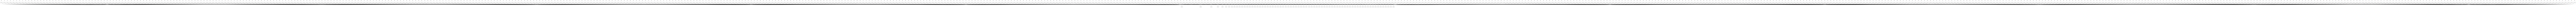

In [65]:
dask.visualize(*inSitu_obs_dfs_list)

But its so massive it can not fit properly in jupyter notebook

In [66]:
# Recomended 64 GB memory
# the task graph initialization takes up 18 GB alone
if False : #do not run
    inSitu_dfs_global = dask.compute(*inSitu_obs_dfs_list)
    inSitu_dfs_global = pd.concat(inSitu_dfs_global)
    
    with open('./inSitu_dfs_global.pkl', 'wb') as f:
        pickle.dump(inSitu_dfs_global, f)   

Also we can compute indepently each item, thus requiring much less memory but loading in each iteration the whole image datasets, as a consequence its takes sensibly longer (~ 15 mins) than previous.

We can see the task graph for the first item: 

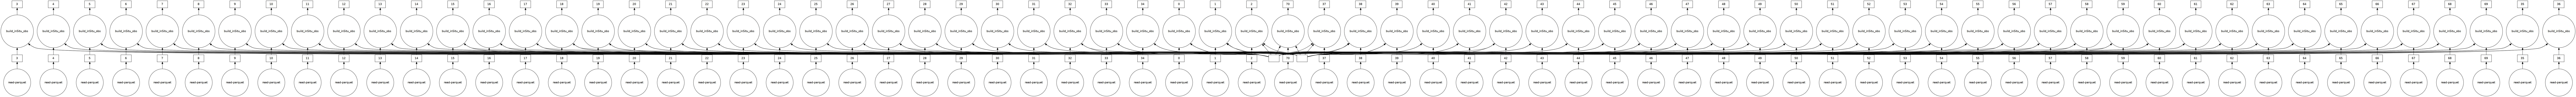

In [67]:
dask.visualize(inSitu_obs_dfs_list[0])

In [68]:
# Recomended 16 GB memory

if False : #do not run
    inSitu_dfs_global = [df.compute() for df in inSitu_obs_dfs_list]
    inSitu_dfs_global = pd.concat(inSitu_dfs_global)
    
    with open('./inSitu_dfs_global.pkl', 'wb') as f:
        pickle.dump(inSitu_dfs_global, f)   

Which alternative to use, depends on the hardware.

In [69]:
with open('./inSitu_dfs_global.pkl', 'rb') as f:
    inSitu_dfs_global = pickle.load(f)

Appliying the mask to mantain only pixels labeled as "VEGETATION" or "NOT_VEGETATED"

In [70]:
mask = (inSitu_dfs_global.loc[:,"scl_value"] == 4) | (inSitu_dfs_global.loc[:,"scl_value"] == 5) #vegetated % not_vegetated only
mask.shape

(852,)

In [71]:
inSitu_dfs_global_masked = inSitu_dfs_global.loc[mask,:]
inSitu_dfs_global_masked.head()

ndvi       str     utm_x      utm_y  \
datetime                                                       
2019-01-20 18:06:49  0.137255  1.131776  586115.0  3510185.0   
2019-01-25 18:06:31  0.120135  1.295199  586115.0  3510185.0   
2019-01-30 18:06:09  0.125749  1.614491  586115.0  3510185.0   
2019-02-04 18:05:31  0.105996  1.037364  586115.0  3510185.0   
2019-03-01 18:02:49  0.125536  1.057225  586115.0  3510185.0   

                                                                 fpath  \
datetime                                                                 
2019-01-20 18:06:49  ./sen2r/out/BOA2/S2B2A_20190120_041_Walnut-Gul...   
2019-01-25 18:06:31  ./sen2r/out/BOA2/S2A2A_20190125_041_Walnut-Gul...   
2019-01-30 18:06:09  ./sen2r/out/BOA2/S2B2A_20190130_041_Walnut-Gul...   
2019-02-04 18:05:31  ./sen2r/out/BOA2/S2A2A_20190204_041_Walnut-Gul...   
2019-03-01 18:02:49  ./sen2r/out/BOA2/S2B2A_20190301_041_Walnut-Gul...   

                     scl_value      dist sensor_name   SM5  theta_d  theta_w  
datetime                                                                      
2019-01-20 18:06:49        5.0  4.991329    rg13vt19  20.0      4.0     37.0  
2019-01-25 18:06:31        5.0  4.991329    rg13vt19  19.0      4.0     37.0  
2019-01-30 18:06:09        5.0  4.991329    rg13vt19  19.0      4.0     37.0  
2019-02-04 18:05:31        5.0  4.991329    rg13vt19  18.0      4.0     37.0  
2019-03-01 18:02:49        5.0  4.991329    rg13vt19  24.0      4.0     37.0

<div class="alert alert-block alert-info">
<b>Note:</b> SM5 its equivallent to $\theta$ in the terminology of sadegui et al 2017
</div>

In [32]:
print("The inSitu_dfs_global has %d in situ measurements, which %d are filtered due to defective values" % (len(inSitu_dfs_global),
                                                                                            len(inSitu_dfs_global) - len(inSitu_dfs_global_masked))  )

The inSitu_dfs_global has 852 in situ measurements, which 225 are filtered due to defective values


In [33]:
mask_delayed = (ddf["scl_value"] == 4) | (ddf["scl_value"] == 5) #vegetated % not_vegetated 
mask = mask_delayed.compute()
mask.shape

(104906050,)

In [35]:
df_global = ddf.loc[:,["str", "ndvi", "scl_value"]].compute()
df_global_masked = df_global.loc[mask,["ndvi", "str"]]

print("The df_global has %d rows (pixels), which %d are filtered due to defective values" % (len(df_global),
                                                                                    len(df_global) - len(df_global_masked)))

The df_global has 104906050 rows (pixels), which 27279405 are filtered due to defective values


Plotting such a vast amount of data requires a more specialized library. [Datashader](https://datashader.org/index.html) is a graphics pipeline system for the representation of large datasets and in this context works very well.

Plotting with `datashader` requires the extent of the axes, it can be computed in parallel too:  

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.435986 to fit


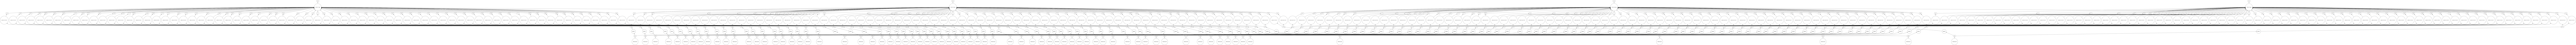

In [36]:
dask.visualize(ddf['ndvi'].min(),
               ddf['ndvi'].max(),
               ddf['str'].max(),
               ddf['str'].min())

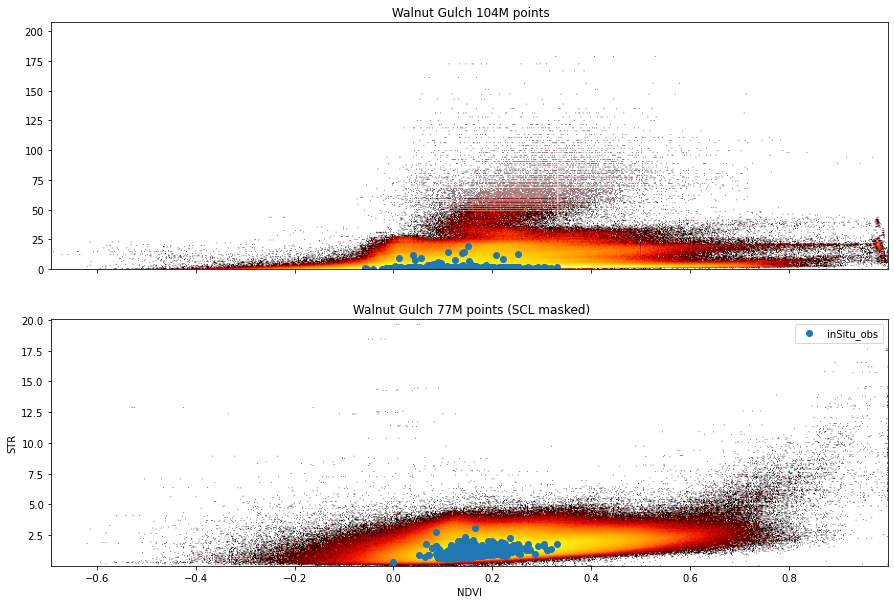

In [37]:
ndvi_min, ndvi_max, str_min, str_max = dask.compute(ddf['ndvi'].min(),
                                                    ddf['ndvi'].max(),
                                                    ddf['str'].min(),
                                                    ddf['str'].max())

ndvi_min_masked, ndvi_max_masked, str_min_masked, str_max_masked = dask.compute(ddf.loc[mask_delayed,'ndvi'].min(),
                                                                                ddf.loc[mask_delayed, 'ndvi'].max(),
                                                                                ddf.loc[mask_delayed,'str'].min(),
                                                                                ddf.loc[mask_delayed,'str'].max())



cvs = ds.Canvas(plot_width=800, plot_height=500)
fig, ax = plt.subplots(2,1, sharey=False, sharex=True, figsize=(15,10))

# RAW PLOT
agg_glob = cvs.points(df_global, 'ndvi', 'str')  # this is the histogram
img_glob = ds.tf.set_background(ds.tf.shade(agg_glob, cmap=cc.fire), "white").to_pil()
ax[0].imshow(img_glob, extent=[ndvi_min, ndvi_max, str_min , str_max],
           aspect='auto',
           origin='upper')
ax[0].scatter(x = inSitu_dfs_global.loc[:,"ndvi"],
              y = inSitu_dfs_global.loc[:,"str"], label = "inSitu_obs")

# MASKED PLOT
agg_masked = cvs.points(df_global_masked, 'ndvi', 'str')  # this is the histogram
img_masked = ds.tf.set_background(ds.tf.shade(agg_masked, cmap=cc.fire), "white").to_pil()
ax[1].imshow(img_masked, extent=[ndvi_min_masked,
                                 ndvi_max_masked,
                                 str_min_masked,
                                 str_max_masked],
             aspect='auto',
             origin='upper')
ax[1].scatter(x = inSitu_dfs_global_masked.loc[:,"ndvi"],
              y = inSitu_dfs_global_masked.loc[:,"str"], label = "inSitu_obs")


ax[0].title.set_text(" Walnut Gulch 104M points")
ax[1].title.set_text(" Walnut Gulch 77M points (SCL masked)")
plt.xlabel("NDVI")
plt.ylabel("STR")
plt.legend()

And here is the desired _NDVI-STR_ space. 

Quick remarks : 

- Its interesting to note the in situ measurements observations are clustered in the center of the trapezoid  



- The higher range of NDVI values is orphaned of measurements, this will introduce additional uncertainty when actually satured pixels are confronted with the OPTRAM for predictions.



- The extent of overrepresentation of measurements in the NDVI-STR space in the original paper is unknown, as no evidence of the point spread is provided, however the authors states the following : 
  - _[...]Though only a limited number o fimage were available it should be noted that measured soil moisture values varied over the full rnge from ry to satured, allowing for extensive validation fo OPTRAM and TOTRAM_

<a id='section_6'></a>

## 6 - Model parametrization

Once the _NDVI-STR_ space its build the wet ($STR_w$) and dry ($STR_d$) edges need to be determined.

The edges are modelized by simple linear regresion which coefficentes are determined by visual spection, following the recomendations of sadegui et al 2017.

$$STR_w = m_w\cdot(NDVI - x_w) + y_w$$
$$STR_d = m_d\cdot(NDVI - x_d) + y_d$$

Then the normalized soil water content ($W$) is defined :






$$W = \frac{\theta - \theta_d}{\theta_w - \theta_d} =  \frac{STR - STR_d}{STR_w - STR_d}$$


In [38]:
def W(STRd, STRw, STR):
    return((STR - STRd)/(STRw - STRd))

def STR_f(slope, ndvi, intercept):
    intercept_x  = intercept[0]
    intercept_y  = intercept[1]
    return (slope*(ndvi - intercept_x) + intercept_y) # y = m(x-x1) + y1

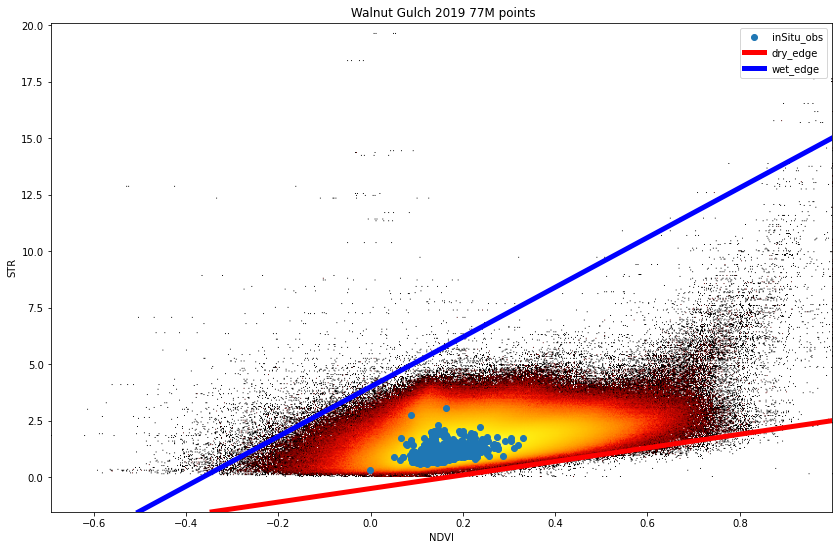

In [39]:
edge_dry_intercept = (0, -0.5)
edge_dry_slope = 3


edge_wet_intercept = (0, 4)
edge_wet_slope = 11


cvs = ds.Canvas(plot_width=800, plot_height=500)  
plt.figure(figsize=(14, 9))

agg_masked = cvs.points(df_global_masked, 'ndvi', 'str') 
img_masked = ds.tf.set_background(ds.tf.shade(agg_masked, cmap=cc.fire), "white").to_pil() 
plt.imshow(img_masked, extent=[ndvi_min_masked,
                               ndvi_max_masked,
                               str_min_masked,
                               str_max_masked],
           aspect='auto',
           origin='upper')

plt.scatter(x = inSitu_dfs_global_masked.loc[:, "ndvi"],
            y = inSitu_dfs_global_masked.loc[:, "str"], label = "inSitu_obs")

plt.axline(edge_dry_intercept, slope=edge_dry_slope,
           linewidth = 5, color='red', label='dry_edge')
plt.axline(edge_wet_intercept, slope=edge_wet_slope,
           linewidth = 5, color='blue', label='wet_edge')

plt.title(" Walnut Gulch 2019 77M points")
plt.xlabel("NDVI")
plt.ylabel("STR")
plt.legend()

The `inSitu_obs` are the satellite image pixels corresponding to the locations of all the soil probes in all the images, thus becoming the ground truth or inSitu measurements

In [40]:
inSitu_dfs_global_masked.loc[:,'str_d'] =  STR_f(intercept = edge_dry_intercept,
                                                 slope = edge_dry_slope,
                                                 ndvi = inSitu_dfs_global_masked.loc[:,'ndvi'])

inSitu_dfs_global_masked.loc[:,'str_w'] =  STR_f(intercept = edge_wet_intercept,
                                                 slope = edge_wet_slope,
                                                 ndvi = inSitu_dfs_global_masked.loc[:,'ndvi'])

inSitu_dfs_global_masked.loc[:,"W"] = W(STRd = inSitu_dfs_global_masked['str_d'],
                                        STRw = inSitu_dfs_global_masked['str_w'],
                                        STR  = inSitu_dfs_global_masked['str'])

/tmp/ipykernel_12639/3635182337.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inSitu_dfs_global_masked.loc[:,'str_d'] =  STR_f(intercept = edge_dry_intercept,
/tmp/ipykernel_12639/3635182337.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inSitu_dfs_global_masked.loc[:,'str_w'] =  STR_f(intercept = edge_wet_intercept,
/tmp/ipykernel_12639/3635182337.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [41]:
with open('./inSitu_dfs_global_masked.pkl', 'wb') as f:
    pickle.dump(inSitu_dfs_global_masked, f)   

<AxesSubplot:xlabel='W', ylabel='SM5'>

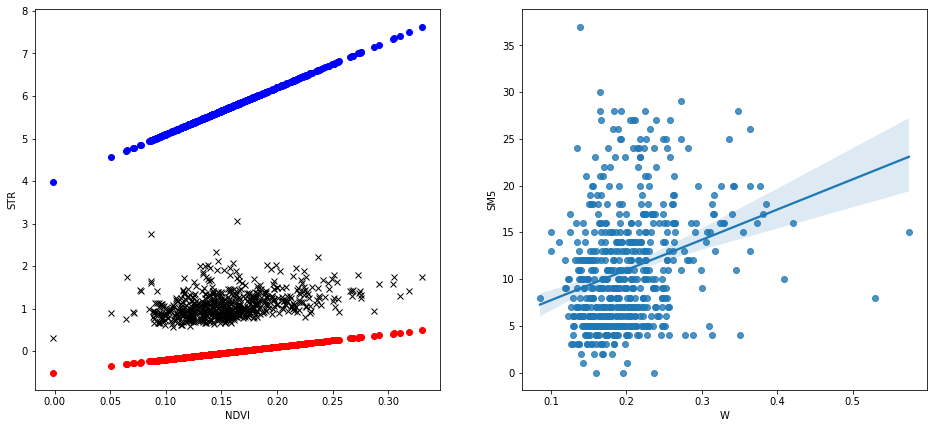

In [42]:
fig, axs = plt.subplots(1,2, figsize = (16, 7))
axs[0].plot('ndvi', 'str_d', 'ro', data = inSitu_dfs_global_masked)
axs[0].plot('ndvi', 'str_w', 'bo', data = inSitu_dfs_global_masked)
axs[0].plot('ndvi', 'str', 'kx', data = inSitu_dfs_global_masked)
axs[0].set(xlabel="NDVI", ylabel="STR")

#sns.regplot(x="ndvi", y="str", data=inSitu_dfs_global_masked, ax=axs[1])
sns.regplot(x="W", y="SM5", data=inSitu_dfs_global_masked, ax=axs[1])
#sns.regplot(x="str", y="SM5", data=inSitu_dfs_global_masked, ax=axs[3])

Comments on the right graph:
- as previously noted in the STR-NDVI space image the in situ measurements are constrained to the semi-arid space, in this image: W < 0.5
- altough the points are concentrated in the arid range, the data exhibit a large scatter on the y-axis (SM5 aka $\theta$), which probably is due to the inherent soil physical variability of the locations of the in Situ measurements.

### Alternative $\theta_d$ , $\theta_w$ estimation : Regression analysis

In sadegui et al 2017, the authors propose two ways of computing the local minimun ($\theta_d$) and maximun($\theta_w$) values of soil moisture content based in two scenarios:

- **Scenario 1** : $\theta_d$ , $\theta_w$ are determined via linear regression analysis of RS-based $W$ data and in situ measued $\theta$ data.
- **Scenario 2** : $\theta_d$ , $\theta_w$ are computed as the minimum and maximum $\theta$ at each station during the sampling period.



The scenario 2 $\theta$-values are already estimated in the function `build_inSitu_obs()` and available in the column `theta_d` and `theta_w` respectively, in the `inSitu_dfs_global_masked` dataframe.


The scenario 1 estimation is more complex because of the need to fit a linear regresion for each station to obtain the $\theta_d (W=0)$ and $\theta_w (W=1)$ . The following cell computes $\theta_d$ , $\theta_w$ for each station and store it as `theta_d_reg` and `theta_w_reg` respectively, in the `inSitu_dfs_global_masked` dataframe.

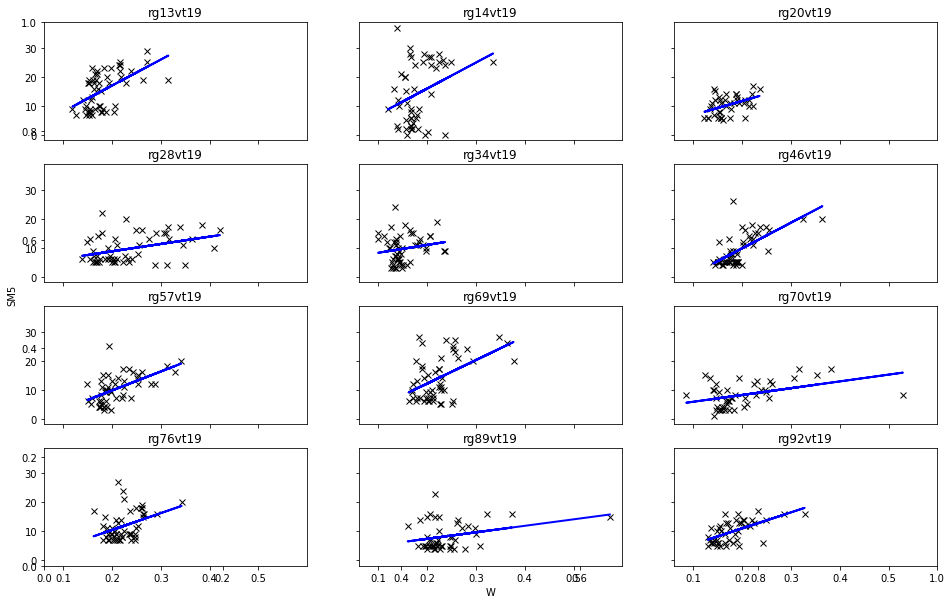

In [43]:
sensor_names = np.unique(inSitu_dfs_global_masked["sensor_name"])

nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize = (16, 10), sharex = True, sharey = True)
fig.add_subplot(111, frameon=False)
plt.xlabel("W")
plt.ylabel("SM5")
for sensor, ax in zip(sensor_names, axs.ravel()) : 
    dataset = inSitu_dfs_global_masked.loc[inSitu_dfs_global_masked['sensor_name'] == sensor,["W", "SM5"]]
    dataset = dataset.dropna()
    X = dataset["W"].values.reshape(-1,1)
    y = dataset["SM5"].values.reshape(-1,1)

    lm = linear_model.LinearRegression()
    lm.fit(X, y)
    theta_d_reg = lm.predict([[0]]) # W = 0
    theta_w_reg = lm.predict([[1]]) # W = 1
    
    inSitu_dfs_global_masked.loc[inSitu_dfs_global_masked['sensor_name'] == sensor,["theta_d_reg"]] = theta_d_reg
    inSitu_dfs_global_masked.loc[inSitu_dfs_global_masked['sensor_name'] == sensor,["theta_w_reg"]] = theta_w_reg
    
    ax.plot(X, y, "kx")
    ax.plot(X, lm.predict(X), color="blue", linewidth=2)
    ax.set_title(sensor)

Then the $W$ values are converted to volumetric soil moisture units using $\theta_d$, $\theta_w$ in each scenario for further comparison.

$$\hat\theta = W \cdot (\theta_w - \theta_d) + \theta_d$$

In [44]:
inSitu_dfs_global_masked.loc[:,"SM5_hat"]     = inSitu_dfs_global_masked["W"].values*(inSitu_dfs_global_masked['theta_w']     - inSitu_dfs_global_masked['theta_d'])     + inSitu_dfs_global_masked['theta_d']
inSitu_dfs_global_masked.loc[:,"SM5_hat_reg"] = inSitu_dfs_global_masked["W"].values*(inSitu_dfs_global_masked['theta_w_reg'] - inSitu_dfs_global_masked['theta_d_reg']) + inSitu_dfs_global_masked['theta_d_reg']

/tmp/ipykernel_12639/2251190169.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inSitu_dfs_global_masked.loc[:,"SM5_hat"]     = inSitu_dfs_global_masked["W"].values*(inSitu_dfs_global_masked['theta_w']     - inSitu_dfs_global_masked['theta_d'])     + inSitu_dfs_global_masked['theta_d']
/tmp/ipykernel_12639/2251190169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inSitu_dfs_global_masked.loc[:,"SM5_hat_reg"] = inSitu_dfs_global_masked["W"].values*(inSitu_dfs_global_masked['theta_w_reg'] - inSitu_df

[Text(0.5, 0, 'Measured Soil Moisture (%)'),
 Text(0, 0.5, 'Estimated Soil Moisture (%)')]

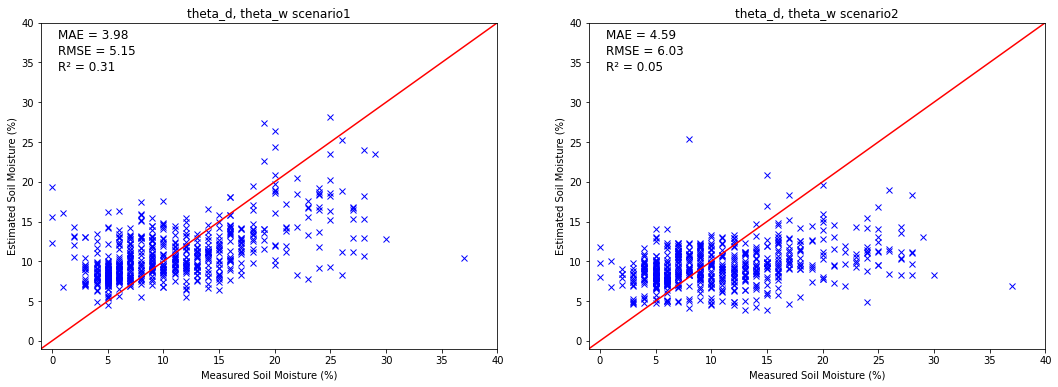

In [45]:
#SM5_max = max(np.maximum(inSitu_dfs_global_masked.loc[:,"SM5_hat_reg"],
#                         inSitu_dfs_global_masked.loc[:,"SM5_hat"],
#                         inSitu_dfs_global_masked.loc[:,"SM5"]))

inSitu_dfs_global_masked = inSitu_dfs_global_masked.dropna()
mae_sc1 = mean_absolute_error(inSitu_dfs_global_masked["SM5"],
                              inSitu_dfs_global_masked["SM5_hat_reg"])

rmse_sc1 = mean_squared_error(inSitu_dfs_global_masked["SM5"],
                              inSitu_dfs_global_masked["SM5_hat_reg"], squared=False)

r_2_sc1 = r2_score(inSitu_dfs_global_masked["SM5"],
                   inSitu_dfs_global_masked["SM5_hat_reg"])

#----
mae_sc2 = mean_absolute_error(inSitu_dfs_global_masked["SM5"],
                              inSitu_dfs_global_masked["SM5_hat"])

rmse_sc2 = mean_squared_error(inSitu_dfs_global_masked["SM5"],
                              inSitu_dfs_global_masked["SM5_hat"], squared=False)

r_2_sc2 = r2_score(inSitu_dfs_global_masked["SM5"],
                   inSitu_dfs_global_masked["SM5_hat"])


#SM5_max = max(np.maximum(inSitu_dfs_global_masked["SM5_hat_reg"].copy(),
#                         inSitu_dfs_global_masked["SM5_hat"].copy(),
#                         inSitu_dfs_global_masked["SM5"].copy()))


SM5_max = 40
SM5_min = -1

fig, axs = plt.subplots(1,2,figsize = (18, 6))

axs[0].title.set_text('theta_d, theta_w scenario1')
axs[0].plot("SM5","SM5_hat_reg", 'bx',data = inSitu_dfs_global_masked)
axs[0].axline((1, 1), slope=1, color = "red")
axs[0].set_xlim([SM5_min, SM5_max])
axs[0].set_ylim([SM5_min, SM5_max])           
axs[0].text(0.5, 38, "MAE = %.2f"%mae_sc1, fontsize=12)
axs[0].text(0.5, 36, "RMSE = %.2f"%rmse_sc1, fontsize=12)
axs[0].text(0.5, 34, "R² = %.2f"%r_2_sc1, fontsize=12)
axs[0].set(xlabel = 'Measured Soil Moisture (%)', ylabel = 'Estimated Soil Moisture (%)')

axs[1].title.set_text('theta_d, theta_w scenario2')
axs[1].plot("SM5", "SM5_hat", 'bx', data = inSitu_dfs_global_masked)
axs[1].axline((1, 1), slope=1, color = "red")
axs[1].set_xlim([SM5_min, SM5_max])
axs[1].set_ylim([SM5_min, SM5_max])  
axs[1].text(0.5, 38, "MAE = %.2f"%mae_sc2, fontsize=12)
axs[1].text(0.5, 36, "RMSE = %.2f"%rmse_sc2, fontsize=12)
axs[1].text(0.5, 34, "R² = %.2f"%r_2_sc2, fontsize=12)
axs[1].set(xlabel = 'Measured Soil Moisture (%)', ylabel = 'Estimated Soil Moisture (%)')


$\theta$ values in scenario 1 led to better results, but obviously some underfitted stations  are having a very negative effect on the overall performance of the adjustment, lets check it out :

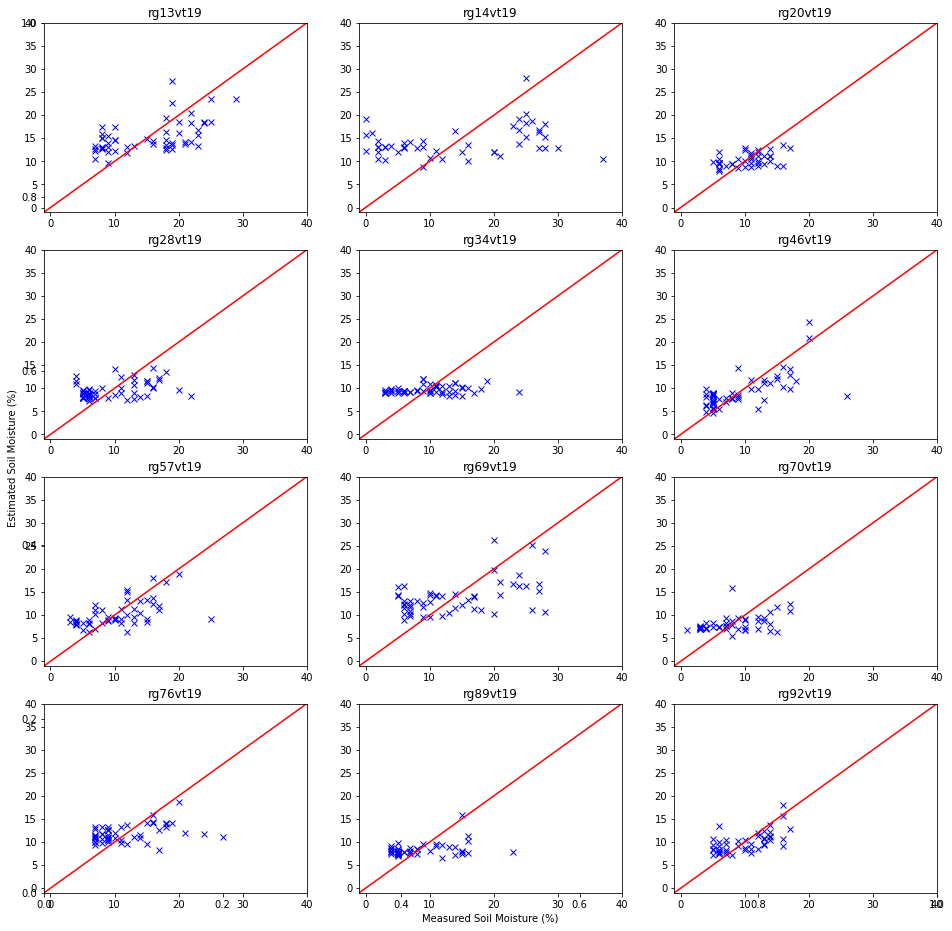

In [46]:
nrow = 4
ncol = 3
fig, axs = plt.subplots(nrow, ncol, figsize = (16, 16))
fig.add_subplot(111, frameon=False)
plt.xlabel('Measured Soil Moisture (%)')
plt.ylabel('Estimated Soil Moisture (%)')
for sensor, ax in zip(sensor_names, axs.ravel()) : 
    dataset = inSitu_dfs_global_masked.loc[inSitu_dfs_global_masked['sensor_name'] == sensor,["SM5_hat_reg", "SM5"]]
    ax.plot(dataset['SM5'], dataset['SM5_hat_reg'], "bx")
    ax.set_xlim([SM5_min, SM5_max])
    ax.set_ylim([SM5_min, SM5_max])
    ax.axline((1, 1), slope=1, color = "red")
    ax.set_title(sensor)

 The sensor stations
 - **rg14vt19**
 - **rg34vt19**

show a particularly unfavorable outcome, more research is needed to determine why. The model would benefit from the elimination of these variables at the risk of biasing it, in this analysis we will keep them.
 

<a id='section_7'></a>
## 7 - $W$ maps

Finally the $W$ maps can be computed for the images

In [47]:
def computeW_by_px(ndvi, str_,
                   i_d = edge_dry_intercept, 
                   s_d = edge_dry_slope,
                   i_w = edge_wet_intercept,
                   s_w = edge_wet_slope) : 

    STRd = STR_f(intercept = i_d,
                 slope = s_d,
                 ndvi = ndvi)
    STRw = STR_f(intercept = i_w,
                 slope = s_w,
                 ndvi = ndvi)
    w  = W(STRd, STRw, STR)
    return(w)

colors = ["red", "darkorange", "yellow", "palegreen", "springgreen", "cyan", "blue"]
custom_cmap_w = LinearSegmentedColormap.from_list("mycmap", colors)

In [48]:
#np.random.seed(4)
nsample = 5
sample = random.sample(range(0, len(boa_files)), nsample)
sample

[11, 63, 53, 73, 14]

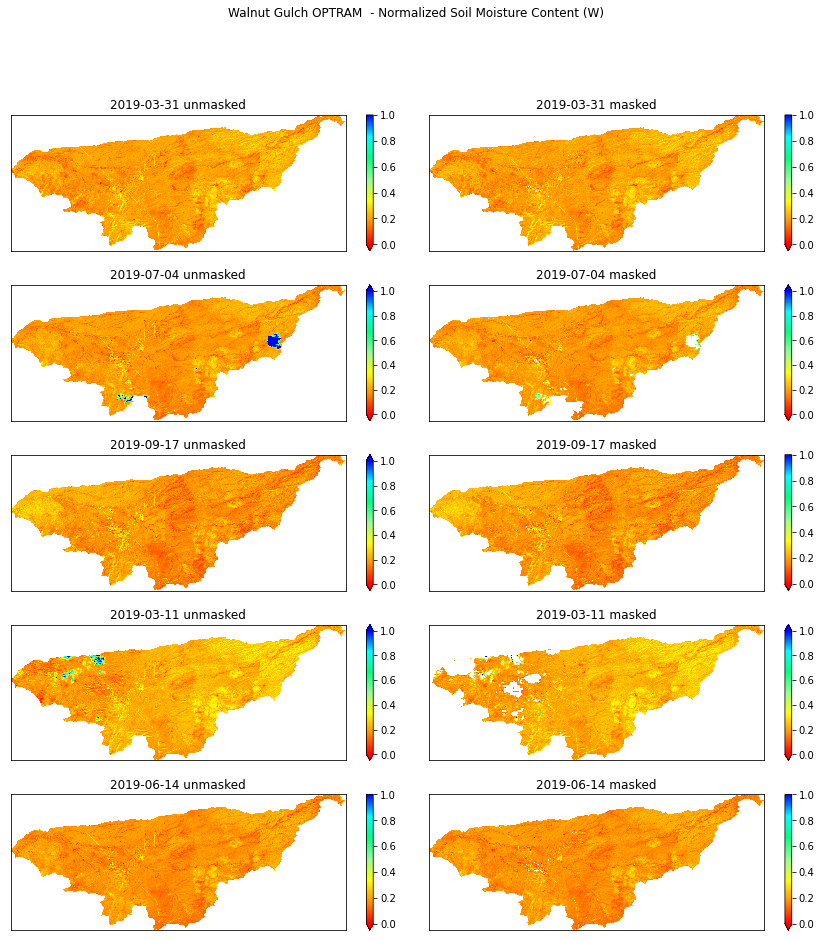

In [49]:
boa_files = [f for f in os.listdir(BASE_DIR_BOA) if os.path.isfile(os.path.join(BASE_DIR_BOA, f))]

ncol = 2
nrow = nsample 
boa_files_sample = [boa_files[i] for i in sample]
fig, axes = plt.subplots(nrow, ncol, figsize=(15,3*nrow),
                         sharex = True,
                         sharey = True,
                         constrained_layout = False)


for idx, boa_fp in enumerate(boa_files_sample) : 
    
    try : 
        boa_fp = BASE_DIR_BOA + boa_fp
        raster_date = S2_getDate(boa_fp)
        scl_fp = S2_getIndex("./sen2r/out/SCL_res10/", raster_date)
        ndvi_fp = S2_getIndex(BASE_DIR_NDVI, raster_date)

        scl = rioxarray.open_rasterio(scl_fp, masked=True)
        scl = scl[0]
        scl = scl.rename({'band':'scl',
                           'x':'lat',
                           'y':'long'})

        ndvi = rioxarray.open_rasterio(ndvi_fp, masked=True)
        ndvi = ndvi[0]
        ndvi = ndvi.rename({'band':'ndvi',
                            'x':'lat',
                            'y':'long'})

        boa  = rioxarray.open_rasterio(boa_fp, masked=True)
        swir = boa[10]/10000
        swir = swir.rename({'band':'STR',
                            'x':'lat',
                            'y':'long'})

        STR  = ((1-swir)**2)/(2*swir)

        w = computeW_by_px(ndvi, STR,
                           i_d = edge_dry_intercept, 
                           s_d = edge_dry_slope,
                           i_w = edge_wet_intercept,
                           s_w = edge_wet_slope)

        w_masked = w.where(
                            (scl == 4) | # vegetation
                            (scl == 5) | # not_vegetated
                            (scl == 6)   # water
                          ) 

        w.plot(ax=axes[idx,0], cmap = custom_cmap_w, vmin = 0, vmax = 1)
        w_masked.plot(ax=axes[idx,1], cmap = custom_cmap_w, vmin = 0, vmax = 1)
        axes[idx,0].title.set_text("%s unmasked" % raster_date.date())
        axes[idx,1].title.set_text("%s masked" % raster_date.date())

        axes[idx,0].set_xticks([])
        axes[idx,0].set_yticks([])
        axes[idx,1].set_xticks([])
        axes[idx,1].set_xticks([])

        axes[idx,0].axes.xaxis.set_visible(False)
        axes[idx,0].axes.yaxis.set_visible(False)
        axes[idx,1].axes.xaxis.set_visible(False)
        axes[idx,1].axes.yaxis.set_visible(False)
        
    except Exception as e :
        print("An error occurred while reading data for file %s " % boa_fp)
        print("Original message: %s " % e)
     

plt.subplots_adjust(wspace=0, hspace=0.25)
fig.suptitle("Walnut Gulch OPTRAM  - Normalized Soil Moisture Content (W)")
plt.show()

Ending remarks : 
- Mainly the pixels are masked because of clouds, its obvious W is saturated in this structures.
- The WG area is very homogenous, with a tipical low water content in the surface.
- The aparent homogeneity in the maps, could be the consecuence of a overrepresentation of arid observations in the in situ measurements as it was discussed in [Data fusion](#section_5) and [Model parametrization](#section_6) sections.

Its to be noted that the W maps **are not in volumetric units**, this is achieved by applying the regression model $SM5$ ~ $W$, but its not cover by the original paper. In a coming notebook several alternatives to obtain the volumetric $\theta$ maps will be implemented.

In [50]:
client.close()